In [3]:
import pandas as pd
from matplotlib import pyplot as plt

In [8]:
df = pd.read_csv('/Users/malwina.natkaniec/Downloads/ox_rev.csv')

In [9]:
df.head()

,ReportDay,SF_name,IS_NEW_PUB,MKT_DEM_SPEND_USD,MKT_PUB_REV_USD,OX_REVENUE,TOTAL_REQUESTS,MKT_REQUESTS,FILLS,MKT_IMPRESSIONS
0,2021-06-28,Automatad,False,672.562712,490.360576,182.202136,110839218,62063383.0,12157056.0,405852.0
1,2021-06-28,Mind Tank Media,False,1070.386924,846.429989,223.956935,75376144,55641408.0,17629858.0,357401.0
2,2021-06-28,Discovery NZ (Previously Mediaworks),False,26.216096,22.270789,3.945307,1687567,1269502.0,133579.0,18578.0
3,2021-06-28,United Online,False,867.309795,730.130310,137.179485,54361360,45836959.0,14674546.0,1299466.0
4,2021-06-28,Barstool Sports,False,2.741228,2.129037,0.612191,7934723,7192490.0,1740494.0,168.0


In [22]:
# df['ReportDay'].unique()

In [16]:
df_daily = df.groupby(["ReportDay"])["OX_REVENUE"].sum().reset_index()
df_daily.head()

,ReportDay,OX_REVENUE
0,2021-06-28,334611.349557
1,2021-06-29,337116.243923
2,2021-06-30,318582.769268
3,2021-07-01,259151.568894
4,2021-07-02,253966.165114


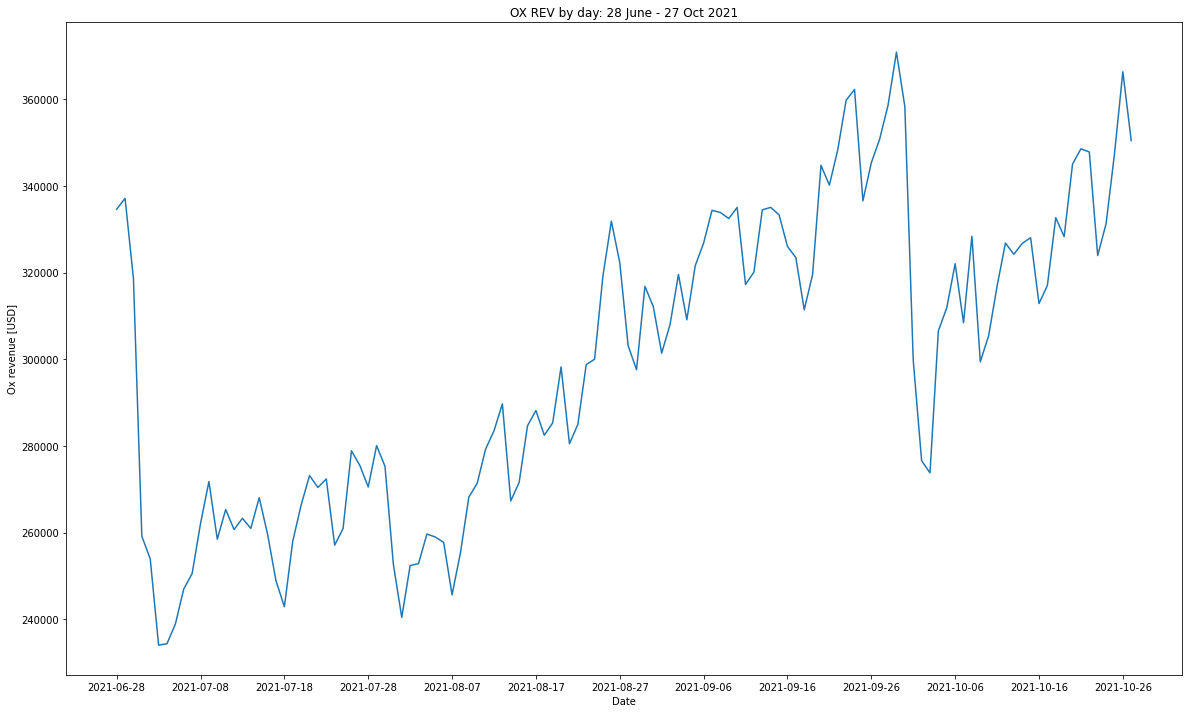

In [40]:
fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(1, 1, 1)
max_xticks = 15
xloc = plt.MaxNLocator(max_xticks)
ax.xaxis.set_major_locator(xloc)
plt.title("OX REV by day: 28 June - 27 Oct 2021")
plt.ylabel("Ox revenue [USD]")
plt.xlabel("Date")
plt.plot('ReportDay', "OX_REVENUE", data=df_daily)


(array([ 5.,  4., 16.,  9., 11.,  8.,  2.,  9.,  7., 15., 14.,  7.,  9.,
         3.,  3.]),
 array([234035.46338  , 243155.9200782, 252276.3767764, 261396.8334746,
        270517.2901728, 279637.746871 , 288758.2035692, 297878.6602674,
        306999.1169656, 316119.5736638, 325240.030362 , 334360.4870602,
        343480.9437584, 352601.4004566, 361721.8571548, 370842.313853 ]),
 <BarContainer object of 15 artists>)

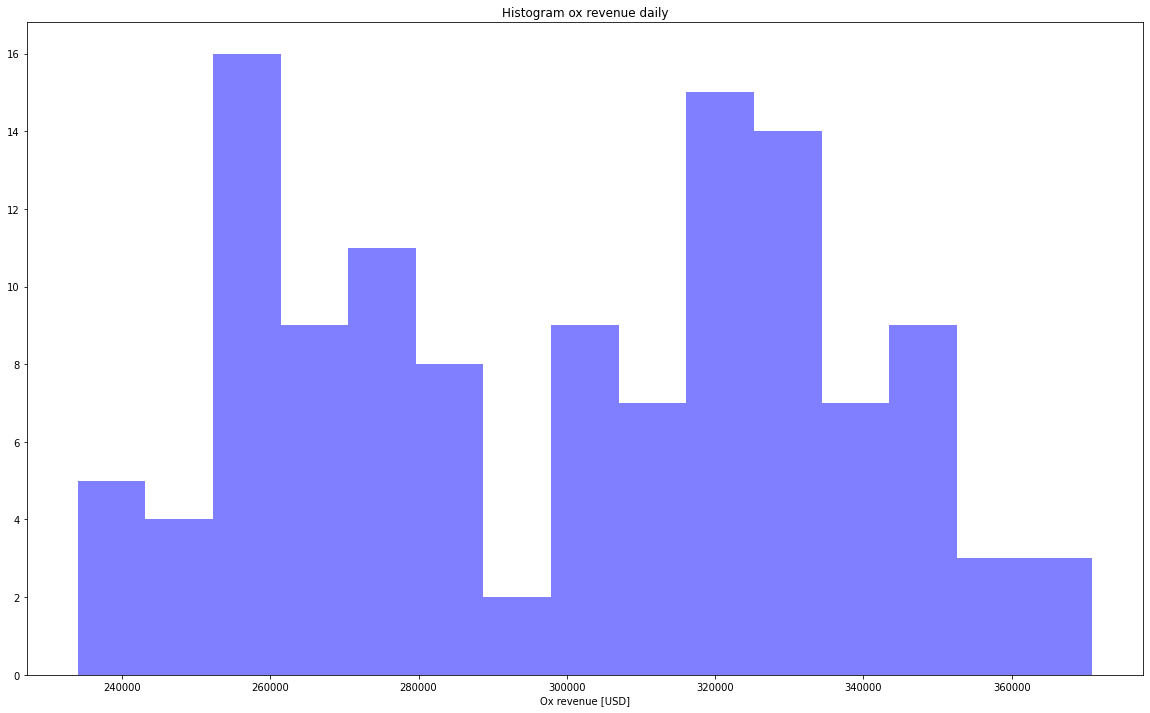

In [54]:
fig = plt.figure(figsize=(20, 12))
# ax = fig.add_subplot(1, 1, 1)
max_xticks = 15
xloc = plt.MaxNLocator(max_xticks)
ax.xaxis.set_major_locator(xloc)
plt.title("Histogram ox revenue daily")

num_bins = 15

# plt.ylabel("Ox revenue [USD]")
plt.xlabel("Ox revenue [USD]")
# plt.plot("OX_REVENUE", data=df_daily, type="hist")
plt.hist(df_daily["OX_REVENUE"], num_bins, facecolor='blue', alpha=0.5)
